# Study of historical data

In [16]:
import json
from datetime import datetime
import pytz
import pandas as pd
import matplotlib.pyplot as plt
from loguru import logger
import itertools

# global constants
filename = '20200715-E7S2WK4HFP-br.jsonl'

def parse_file(n_lines=None):
    with open(filename) as infile:
        if n_lines is not None: # only read at most n_lines
            file_iterator = itertools.islice(infile,n_lines,n_lines+500000)
        else:
            file_iterator = infile
        all_dict = list(map(json.loads,file_iterator))
        logger.info("Loaded {} rows",len(all_dict))
        return all_dict
    
def create_frame(br_object):
    deals = br_object['Bidrequest']['imp'][0]['pmp']['deals']
    for deal in deals:
        if deal['id'] == "E7S2WK4HFP":
            price = deal['bidfloor'] 
    record={
        'ts': br_object['Timestamp_status_receive_ms']/1000,
        'TZ': br_object['Timezone'],
        'Date': datetime.fromtimestamp(br_object['Timestamp_status_receive_ms']/1000, 
                                       tz = pytz.timezone(br_object['Timezone'])).strftime("%Y-%m-%d"),
        'hour': datetime.fromtimestamp(br_object['Timestamp_status_receive_ms']/1000, 
                                       tz = pytz.timezone(br_object['Timezone'])).hour,
        'imps': br_object['Imps'],
        'CPM': price
        }
    record['price'] = (record['imps'] * record['CPM']) / 1000
    return record

In [17]:
# We have to load 6 000 000 lines
first = True
N_LINES = 0
while N_LINES < 5500000:
    if first:
        first = False
        all_dicts = parse_file(n_lines=N_LINES)
        records = list(map(create_frame, all_dicts))
        df = pd.DataFrame.from_records(records).sort_values("ts",ascending=True)
    else:
        N_LINES += 500000
        all_dicts = parse_file(n_lines=N_LINES)
        records = list(map(create_frame, all_dicts))
        df = df.append(pd.DataFrame.from_records(records).sort_values("ts",ascending=True))  

2020-07-16 17:30:07.884 | INFO     | __main__:parse_file:19 - Loaded 500000 rows
2020-07-16 17:30:30.591 | INFO     | __main__:parse_file:19 - Loaded 500000 rows
2020-07-16 17:30:59.983 | INFO     | __main__:parse_file:19 - Loaded 500000 rows
2020-07-16 17:31:25.346 | INFO     | __main__:parse_file:19 - Loaded 500000 rows
2020-07-16 17:31:50.910 | INFO     | __main__:parse_file:19 - Loaded 500000 rows
2020-07-16 17:32:17.796 | INFO     | __main__:parse_file:19 - Loaded 500000 rows
2020-07-16 17:32:47.398 | INFO     | __main__:parse_file:19 - Loaded 500000 rows
2020-07-16 17:33:18.520 | INFO     | __main__:parse_file:19 - Loaded 500000 rows
2020-07-16 17:33:46.456 | INFO     | __main__:parse_file:19 - Loaded 500000 rows
2020-07-16 17:34:31.591 | INFO     | __main__:parse_file:19 - Loaded 500000 rows
2020-07-16 17:35:17.459 | INFO     | __main__:parse_file:19 - Loaded 500000 rows
2020-07-16 17:36:06.014 | INFO     | __main__:parse_file:19 - Loaded 500000 rows


In [18]:
timezone = df.groupby(df['TZ']).size()

In [19]:
timezone.sort_values()

TZ
America/Kentucky/Louisville        5337
America/Indiana/Indianapolis      19413
America/Boise                     28630
America/Denver                    67974
America/Phoenix                   73624
America/Detroit                  117554
Europe/London                    203726
America/Los_Angeles              325479
Europe/Paris                     408001
America/Chicago                 2294982
America/New_York                2455280
dtype: int64

In [20]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [21]:
df

,ts,TZ,Date,hour,imps,CPM,price
0,1594166400.042,America/New_York,2020-07-07,20,25.037,9,0.225
1,1594166400.070,America/New_York,2020-07-07,20,27.290,9,0.246
2,1594166400.235,America/Indiana/Indianapolis,2020-07-07,20,14.188,9,0.128
3,1594166400.493,America/Chicago,2020-07-07,19,2.755,9,0.025
4,1594166400.787,Europe/Paris,2020-07-08,2,1.000,6,0.006
...,...,...,...,...,...,...,...
499995,1594782610.286,America/Phoenix,2020-07-14,20,2.582,9,0.023
499996,1594782610.384,America/Chicago,2020-07-14,22,1.570,9,0.014
499997,1594782610.558,America/New_York,2020-07-14,23,10.327,9,0.093
499998,1594782610.800,Europe/Paris,2020-07-15,5,1.000,6,0.006


In [22]:
df2 = df.imps.groupby([df['Date'], df['hour']]).sum().reset_index()

In [23]:
df2

,Date,hour,imps
0,2020-07-07,17,67391.903
1,2020-07-07,18,70925.315
2,2020-07-07,19,194506.000
3,2020-07-07,20,351489.801
4,2020-07-07,21,351650.422
...,...,...,...
176,2020-07-15,1,3580.000
177,2020-07-15,2,3487.000
178,2020-07-15,3,3667.000
179,2020-07-15,4,2545.000


In [24]:
pattern = df2.pivot_table('imps', index = df2.hour, columns=df2.Date)

In [ ]:
del pattern['2020-07-07']
del pattern['2020-07-15']

In [31]:
pattern

Date,2020-07-08,2020-07-09,2020-07-10,2020-07-11,2020-07-12,2020-07-13,2020-07-14
hour,,,,,,,
0,326653.445,333755.764,335727.444,341710.524,340832.918,351658.515,348261.211
1,327254.856,333229.665,335696.567,340844.294,341820.599,349583.230,348228.045
2,330329.481,332695.651,335744.930,341715.027,340428.680,348473.027,347001.277
3,328727.815,334013.339,335354.492,341849.342,341372.627,351182.709,348645.172
4,331946.248,333785.997,336064.963,340288.542,342583.052,350273.463,348574.143
5,350102.416,353757.963,355475.157,360375.368,360654.079,367615.989,366958.826
6,356443.691,356467.894,360532.347,365671.085,365382.949,373697.950,373276.121
7,356631.855,359215.673,361367.399,365991.956,366036.066,373254.894,373437.692
8,358817.035,360205.077,359623.653,366782.463,366548.391,375703.609,376709.306


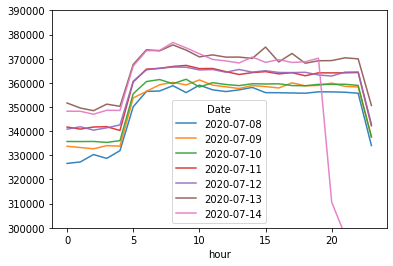

In [32]:
pattern.plot(legend=True, alpha=0.9, ylim = (300000, 390000))

In [36]:
line, col = pattern.shape

In [39]:
for i in range(col):
    pattern.iloc[:,i] = pattern.iloc[:,i]*100/pattern.iloc[:,i].sum()

In [40]:
pattern

Date,2020-07-08,2020-07-09,2020-07-10,2020-07-11,2020-07-12,2020-07-13,2020-07-14
hour,,,,,,,
0,3.892,3.945,3.957,3.968,3.957,4.004,4.285
1,3.899,3.939,3.957,3.958,3.969,3.981,4.285
2,3.936,3.933,3.957,3.968,3.952,3.968,4.270
3,3.917,3.948,3.953,3.970,3.963,3.999,4.290
4,3.955,3.945,3.961,3.952,3.977,3.989,4.289
5,4.172,4.182,4.190,4.185,4.187,4.186,4.515
6,4.247,4.214,4.249,4.247,4.242,4.255,4.593
7,4.249,4.246,4.259,4.250,4.250,4.250,4.595
8,4.276,4.258,4.239,4.259,4.256,4.278,4.635


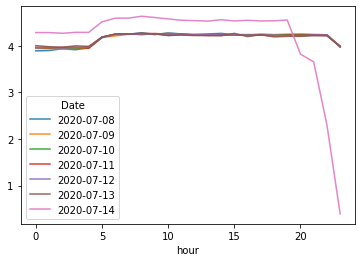

In [44]:
pattern.plot(legend=True, alpha=0.9)

Les proportions d'impressions par heure pour chaque jour sont sensiblement les memes (exeption faite pour le 14 juillet) 